In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *

#from structureSelector2 import *
from methods.utils.utilities import *
import plotly.express as px

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))), 'MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r


# identificação

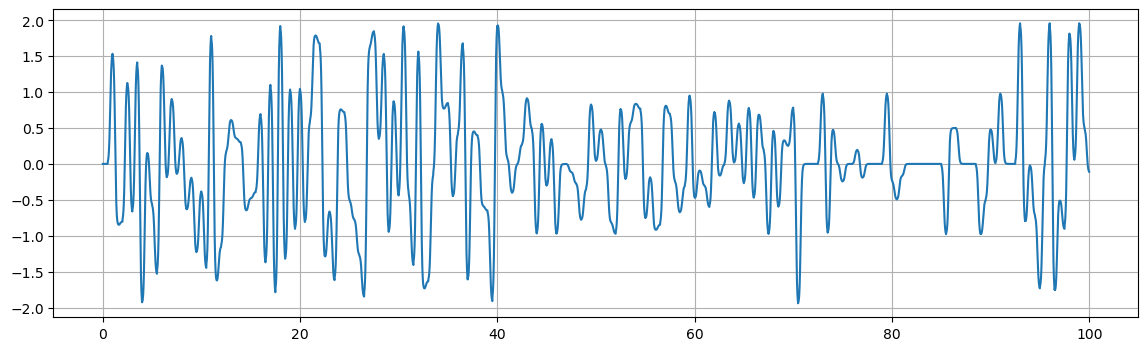

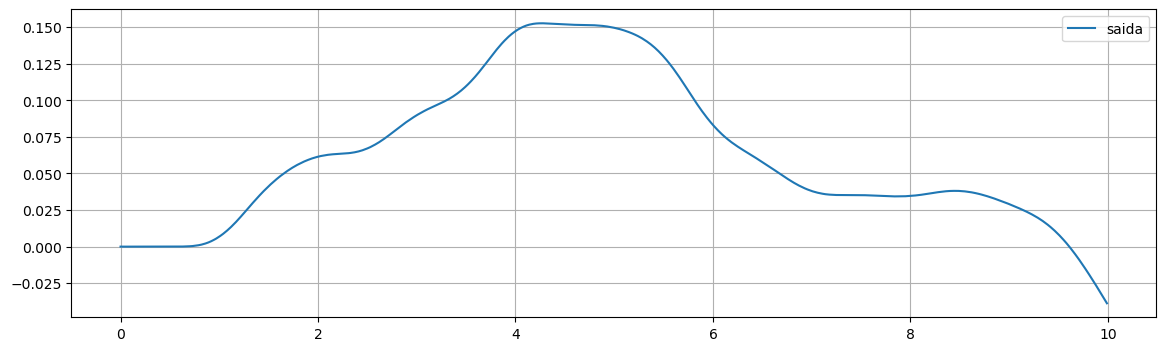

In [22]:
my_data = np.genfromtxt('data/ballBeamSaturado.csv', delimiter=',')[1:,:]
#my_data = np.genfromtxt('data/ballBeamRungeKutta_Est.csv', delimiter=',')[1:,:]
u = my_data[:, 0].copy()
y = my_data[:, 1].copy() 
t = my_data[:, 3].copy()

np.random.seed(15)
amplitude = 0.00001
#u += np.random.uniform(-0.0002, 0.0002, u.shape)
y = y + np.random.uniform(-amplitude, amplitude, y.shape)

dt = my_data[1, 3]
size = 1000
plt.figure(figsize=(14, 4))
plt.plot(t, u*(180/np.pi), label="entrada")
plt.grid()
plt.show()
plt.figure(figsize=(14, 4))
plt.plot(t[:size], y[:size], label="saida")
plt.legend()
plt.grid()
plt.show()

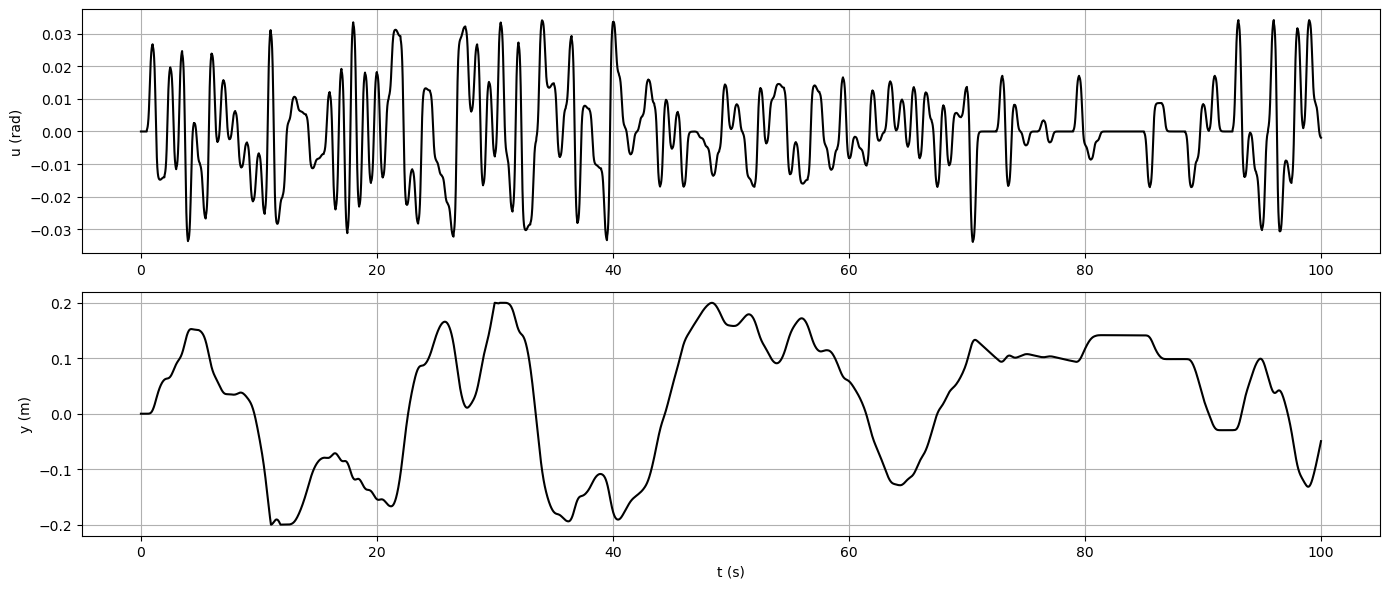

In [23]:
f, ax = plt.subplots(2, 1, figsize=[14, 6])
ax[0].plot(t, u, label='Entrada', color='black')
ax[0].set_ylabel('u (rad)')

ax[1].plot(t, y, label='Saída', color='black')
ax[1].set_ylabel('y (m)')
ax[1].set_xlabel('t (s)')


plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballandbeamEst.png')
ax[0].grid()
ax[1].grid()
plt.show()

# estimacao

### Sem ruído

[clip(Y1.1) clip(Y1.2) sin(U1.1) clip(Y1.3)] [ 2.18867293e+00 -1.37859130e+00  5.24402778e-04  1.89912953e-01] [1, 2, 11, 3]
Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, U1.1, U1.2, U1.3, U1.4]

Simulação livre
RMSE: 0.1500761251229724 MSE: 0.022522843331926064 
AET: 1204.427163956974 
MAPE: 15.26193%


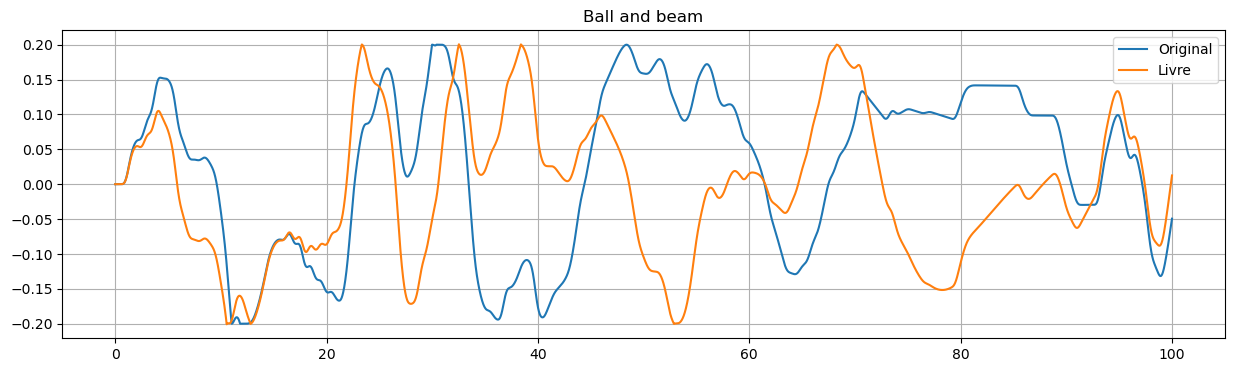

'\ngama = 0.00000000001\nSimulação livre\nRMSE: 0.00042956873591042317 MSE: 1.8452929887167887e-07 \nAET: 2.6567966635407574 \nMAPE: 0.13974%\n'

In [27]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.reshape(my_data[:, 1], (1, -1)).copy()

output = 0  
num = [4]
params = []
params.append({'nb':[4],'na':[4], 'level':1, 'nonlinear':[3,0,0,0,0], 'root':False, 'delay':1, 'diff':False, 'ymodifier':[1,0]})

sselector = structureSelector()
clip.setLimit(-0.2, 0.2)
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]

theta = LSM(yi[output, pad:], psi)
#theta1 = recursiveMQ(yi[output, pad:], psi, pad)
print(model, theta, selected)

model = ss[selected]
#pprint(model)
#print(model @ theta)


slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
print("\nSimulação livre")
metrics(yi, slivre)
'''
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)
print("\nUm passo a frente")
metrics(yi, yhat)
'''
plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, yi.T, label='Original')
#plt.plot(t, yhat, label='um passo a frente')
plt.plot(t, slivre, label='Livre')
plt.legend()
plt.grid()
plt.show()

'''
gama = 0.00000000001
Simulação livre
RMSE: 0.00042956873591042317 MSE: 1.8452929887167887e-07 
AET: 2.6567966635407574 
MAPE: 0.13974%
'''

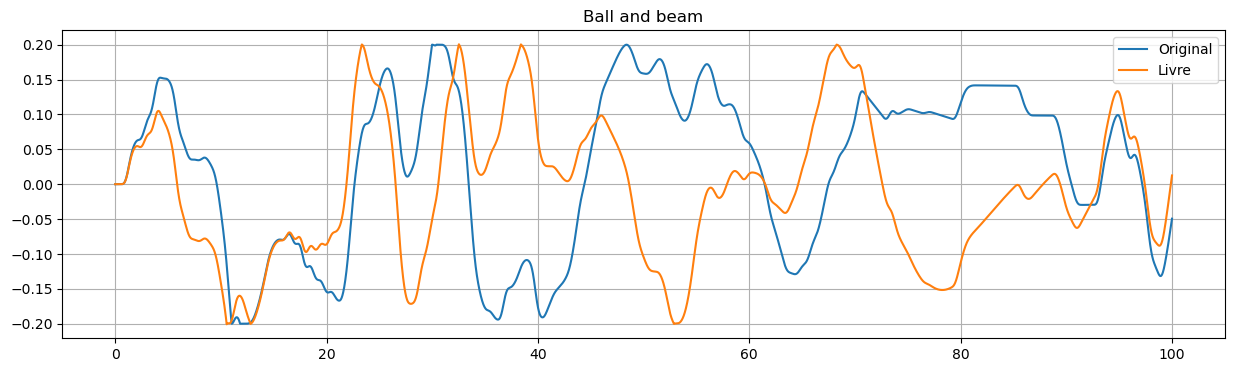

In [29]:
plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, yi.T, label='Original')
#plt.plot(t, yhat, label='um passo a frente')
plt.plot(t, slivre, label='Livre')
plt.legend()
plt.grid()
plt.show()

### Com ruido

[Y1.1 sin(U1.1) sin(Y1.2) Y1.4 Y1.3] [1, 9, 6, 4, 3]
[Y1.1 sin(U1.1) sin(Y1.2) Y1.4 Y1.3]
0.852202419270052*Y1.1 - 0.0181325083427195*Y1.3 - 0.026973871719669*Y1.4 + 0.0708198922475351*sin(U1.1) + 0.191771425920633*sin(Y1.2)
Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, U1.1, U1.2, U1.3]

Simulação livre
RMSE: 0.056333476673608086 MSE: 0.0031734605941359465 
AET: 331.7891598164087 
MAPE: 1.41498%

Um passo a frente
RMSE: 0.002193895230212378 MSE: 4.813176281148624e-06 
AET: 11.105948058739688 
MAPE: 0.80089%


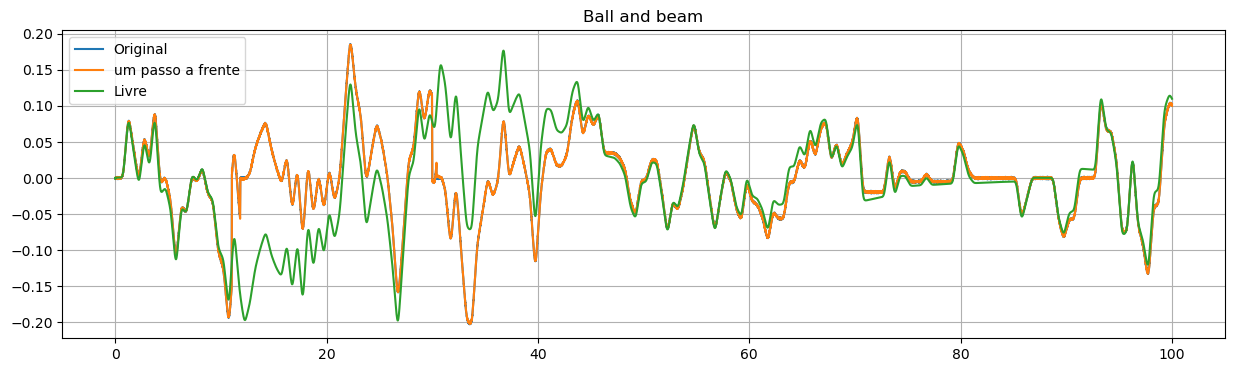

In [13]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.zeros(ui.shape)
yi[0, 1:] = (y[1:] - y[:-1]) / t[1]

output = 0  # 0 ou 1

num = [5]
params = []
params.append({'nb':[4],'na':[3], 'level':1, 'nonlinear':[3,0,0,0,0], 'root':False, 'delay':2, 'diff':False})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

#print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]
print(model, selected)

theta = LSM(yi[output, pad:], psi)
#theta1 = recursiveMQ(yi[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)

print("\nSimulação livre")
metrics(yi, slivre)
print("\nUm passo a frente")
metrics(yi, yhat)

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, yi.T, label='Original')
plt.plot(t, yhat, label='um passo a frente')
plt.plot(t, slivre, label='Livre')
plt.legend()
plt.grid()
plt.show()

## residuo

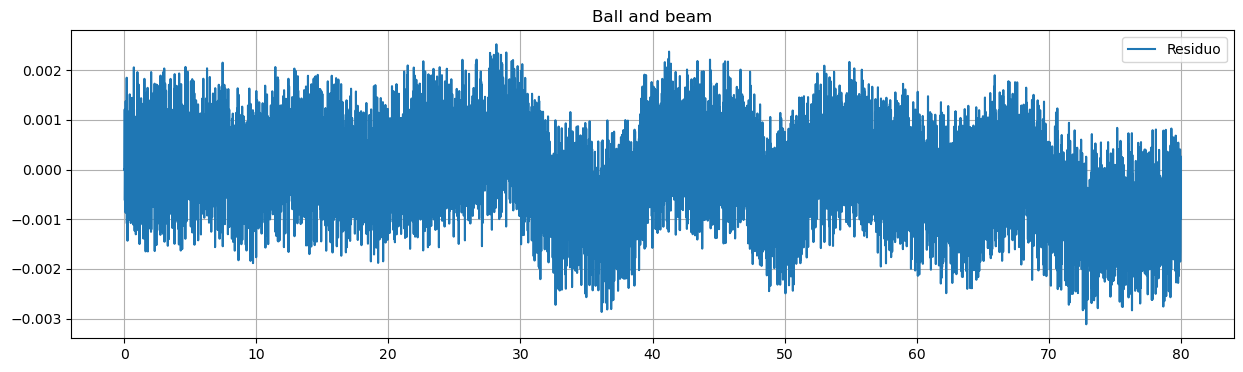

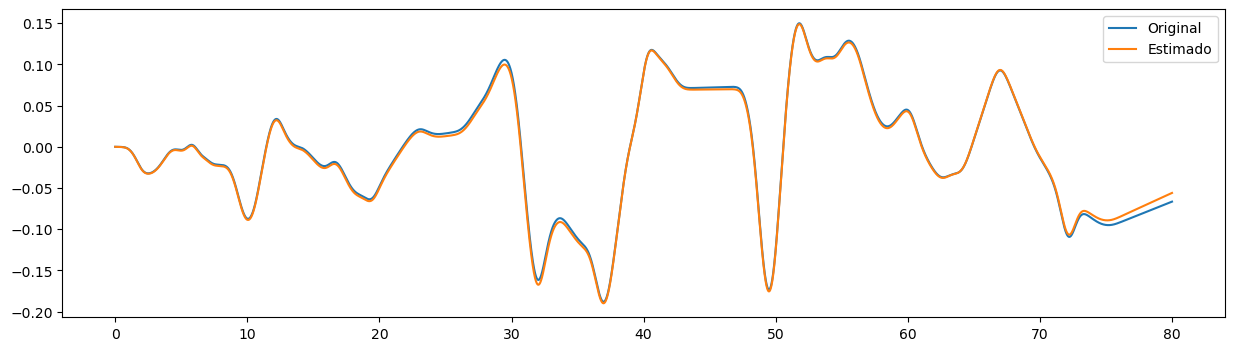

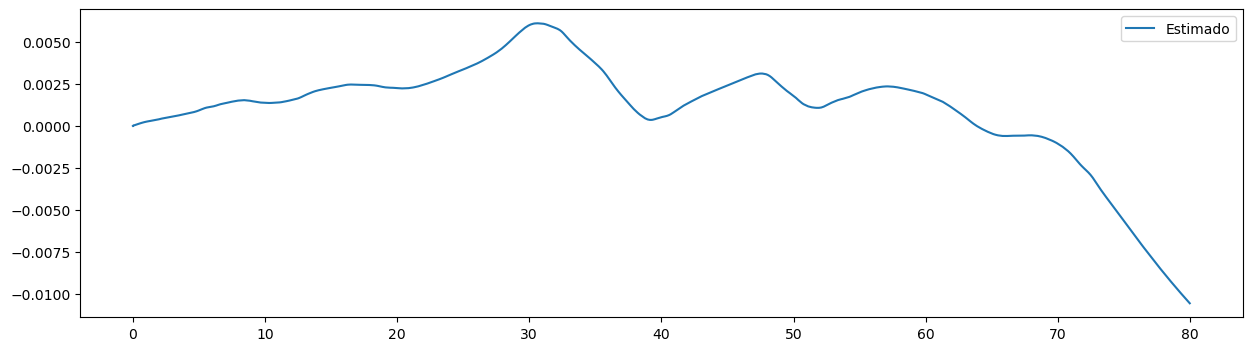

In [7]:
w = integrate(slivre, ts=dt)
yn = my_data[:, 1].copy() 
plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, (yi - slivre.T).T, label='Residuo')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(t, yn, label="Original")
plt.plot(t, w, label="Estimado")
plt.legend()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(t, yn-w, label="Estimado")
plt.legend()
plt.show()

# Validação


0.01


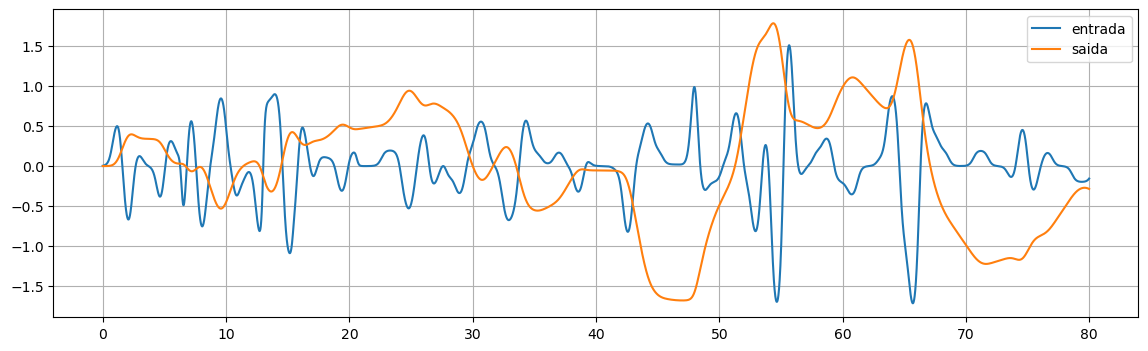

In [20]:

val_data = np.genfromtxt('data/BBRungeKutta_Val.csv', delimiter=',')[1:,:]
uVal = np.reshape(val_data[:, 0], (1, -1))
yValidation = np.reshape(val_data[:, 1], (1, -1))
tVal = val_data[:, -1]

dt = val_data[1, -1]
yVal = np.reshape(val_data[:, 1], (1, -1))
print(dt)
plt.figure(figsize=(14, 4))
plt.plot(tVal, uVal.T*(180/np.pi), label="entrada")
plt.plot(tVal, yValidation.T*10, label="saida")

plt.legend()
plt.grid()
plt.show()

Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, U1.1, U1.2, U1.3, U1.4]
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-

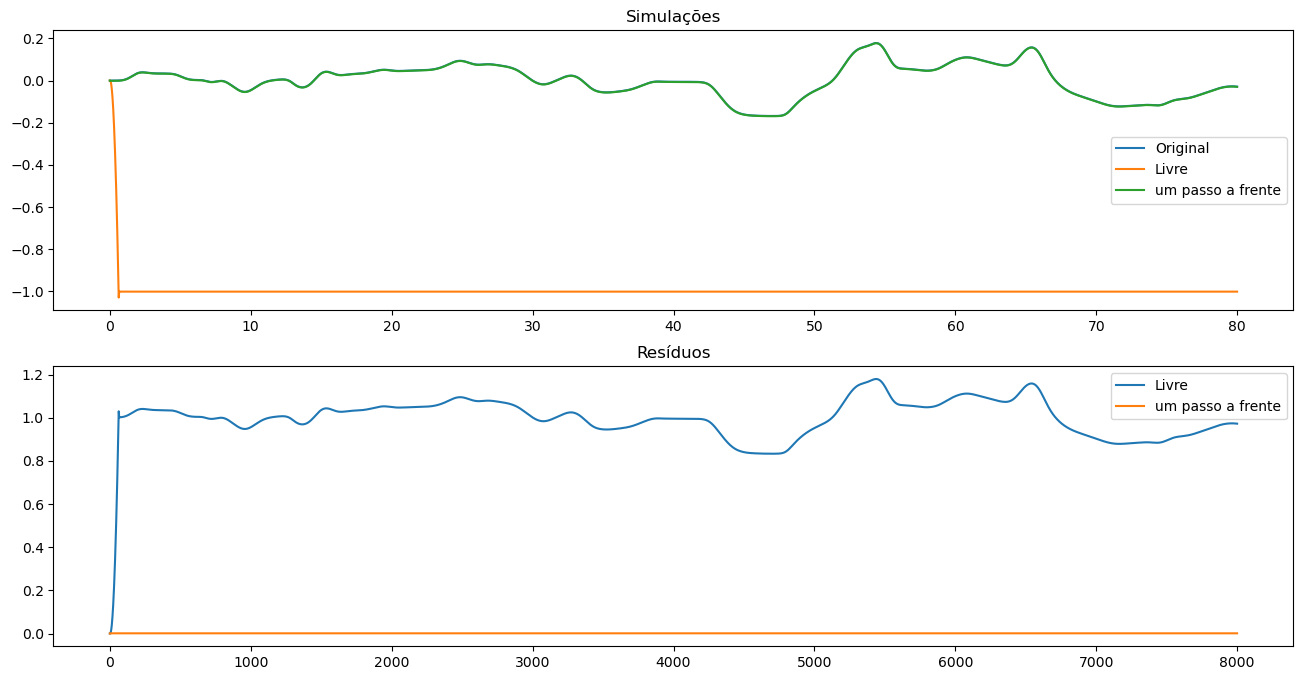

'\nSimulação livre\nRMSE: 0.0002069054383219968 MSE: 4.280986040721762e-08 \nAET: 0.9919382900488835 \nMAPE: 0.03213%\n'

In [25]:
uVal[0] = -1
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

print("\nSimulação livre")
metrics(yVal, valLivre)
print("\nUm passo a frente")
metrics(yVal, yhat)

f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(tVal, yVal[output].T, label='Original')
ax[0].plot(tVal, valLivre, label='Livre')
#ax[0].plot(tVal, integrate(valLivre, ts=tVal[1]), label='Livre')
ax[0].plot(tVal, yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
#ax[1].plot(yVal[output].T - integrate(valLivre, ts=tVal[1]), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

'''
Simulação livre
RMSE: 0.0002069054383219968 MSE: 4.280986040721762e-08 
AET: 0.9919382900488835 
MAPE: 0.03213%
'''

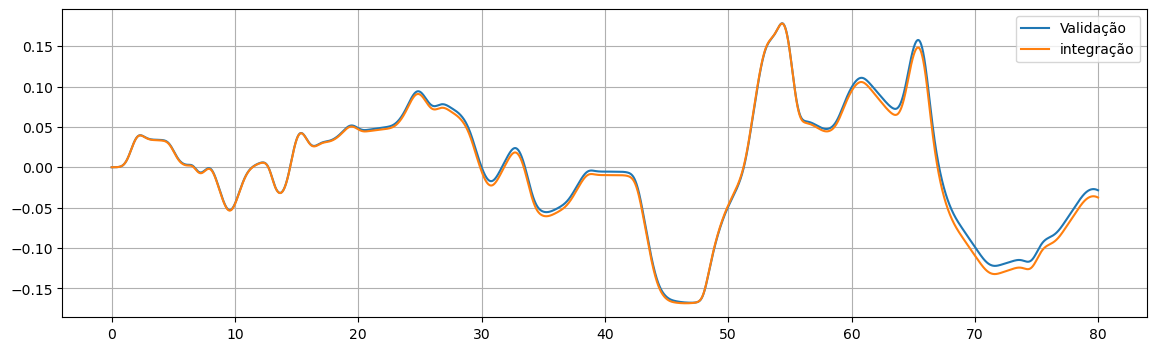

In [24]:
plt.figure(figsize=(14, 4))
plt.plot(tVal, yValidation.T, label="Validação")
plt.plot(tVal, integrate(valLivre, ts=dt), label="integração")
plt.legend()
plt.grid()
plt.show()

# Narx

969 (969, 7992)
[Y1.1 U1.1 U1.3 Y1.7] [1, 9, 11, 7]
[Y1.1 U1.1 U1.3 Y1.7]
0.000955942365577798*U1.1 + 0.00133046762927646*U1.3 + 1.16666728479247*Y1.1 - 0.166667220723264*Y1.7
Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]

Simulação livre
RMSE: 0.012800358450105367 MSE: 0.0001638491764511839 
AET: 61.59371210263999 
MAPE: 0.48689%

Um passo a frente
RMSE: 4.3972469347545336e-07 MSE: 1.9335780605208143e-13 
AET: 0.0028470183102504354 
MAPE: 0.00029%


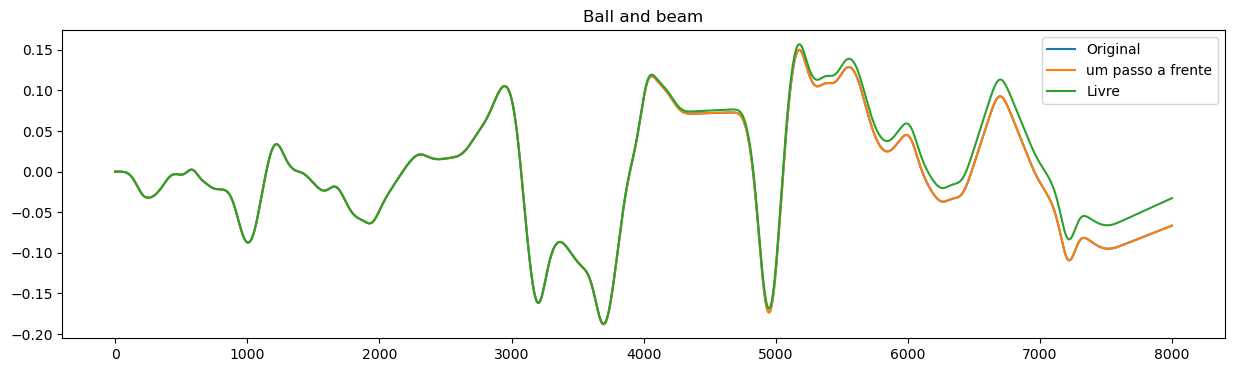

In [82]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.reshape(my_data[:, 1], (1, -1)).copy()

output = 0  # 0 ou 1

'''
num = [4]
params = []
params.append({'nb':[3],'na':[3], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})
'''

num = [8]
params = []
params.append({'nb':[8],'na':[8], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})


sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-15)#0.000000001

model = ss[selected]
print(model, selected)

theta = LSM(yi[output, pad:], psi)
#theta1 = recursiveMQ(yi[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


polinomial_slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)

print("\nSimulação livre")
metrics(yi, polinomial_slivre)
print("\nUm passo a frente")
metrics(yi, yhat)

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(yi.T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(polinomial_slivre, label='Livre')
plt.legend()
plt.show()

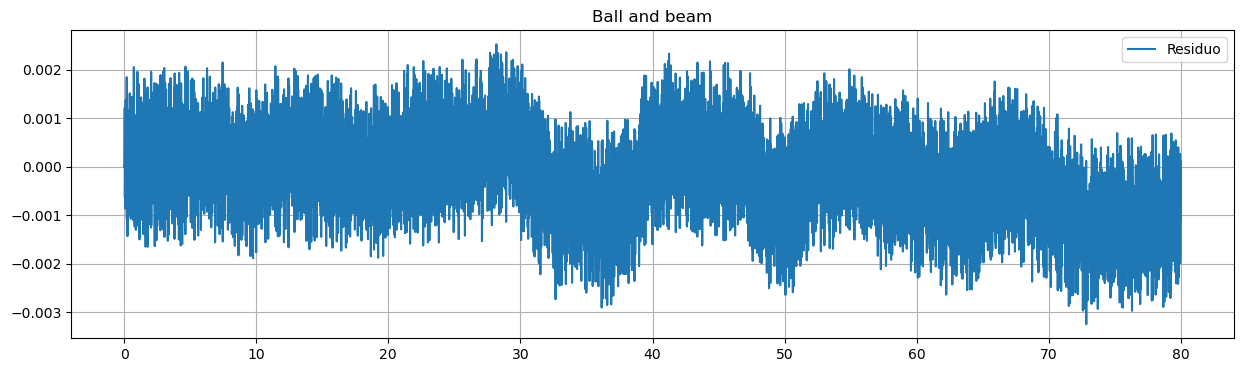

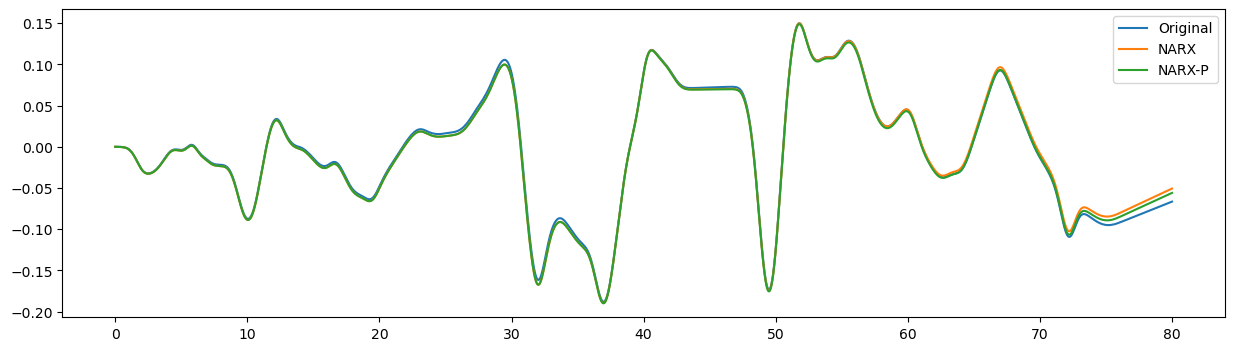

In [88]:

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, (yi - polinomial_slivre.T).T, label='Residuo')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(t, y, label="Original")
plt.plot(t, integrate(polinomial_slivre, ts=dt), label="NARX")
#plt.plot(t, polinomial_slivre, label="NARX")
plt.plot(t, w, label="NARX-P")
plt.legend()
plt.show()

Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
0.000955942365577798⋅U1.1 + 0.00133046762927646⋅U1.3 + 1.16666728479247⋅Y1.1 -
 0.166667220723264⋅Y1.7

Simulação livre
RMSE: 0.0018087309815827616 MSE: 3.2715077637373403e-06 
AET: 11.50733273036175 
MAPE: 0.10176%

Um passo a frente
RMSE: 4.49442477129732e-07 MSE: 2.0199854024850967e-13 
AET: 0.002950594608316709 
MAPE: 0.00018%


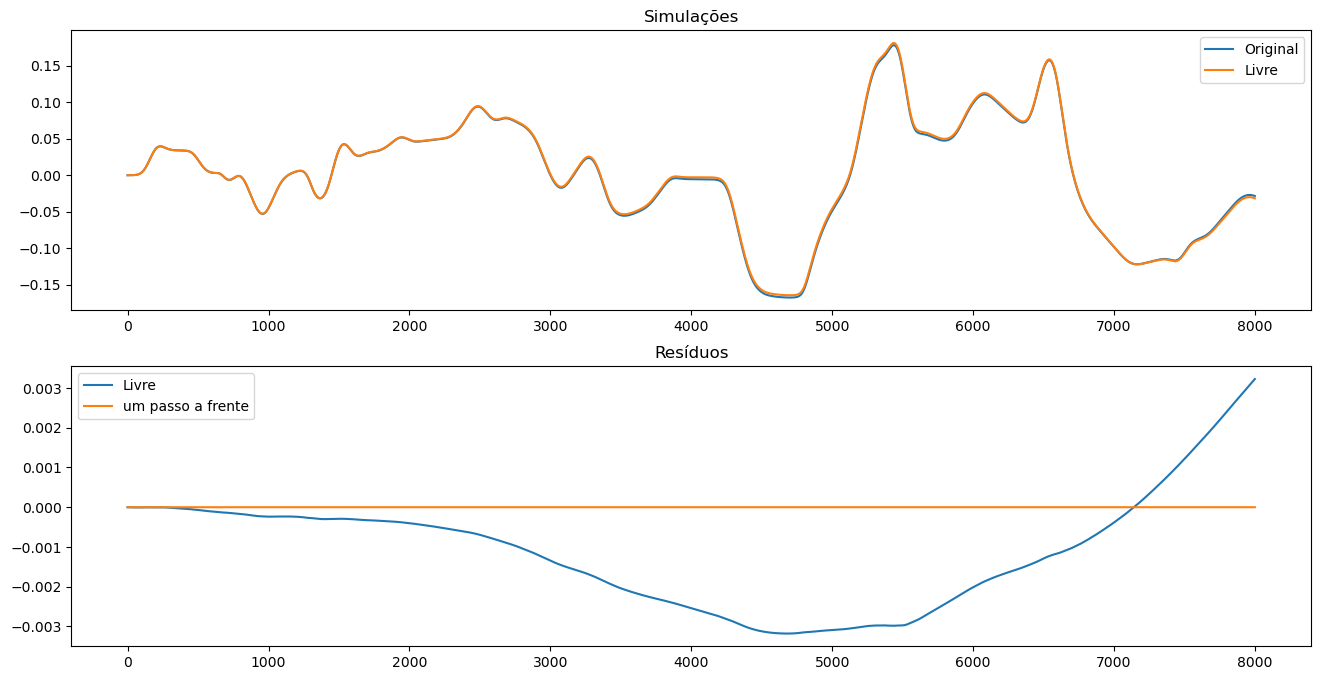

In [9]:
#uVal = UVal
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

print("\nSimulação livre")
metrics(yVal, polinomial_valLivre)
print("\nUm passo a frente")
metrics(yVal, yhat)
f, ax = plt.subplots(2,1, figsize=[16, 8])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(polinomial_valLivre, label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - polinomial_valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

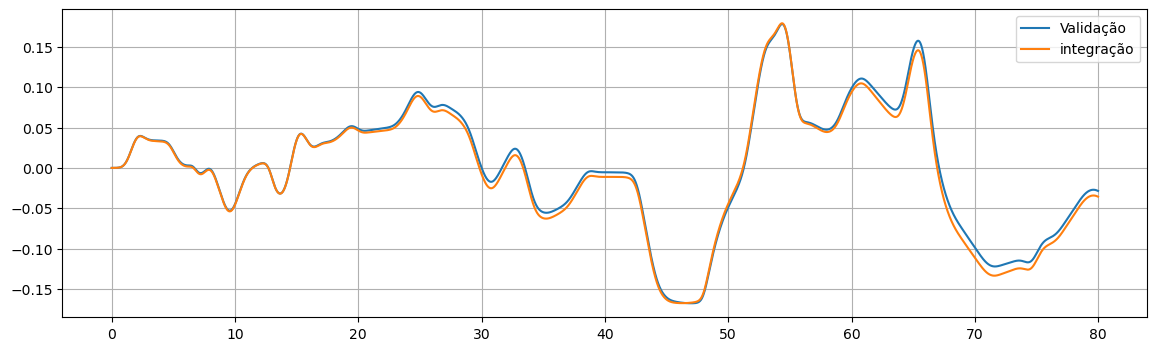

In [57]:
plt.figure(figsize=(14, 4))
plt.plot(tVal, yValidation.T, label="Validação")
plt.plot(tVal, integrate(valLivre, ts=dt), label="integração")
plt.legend()
plt.grid()
plt.show()

## Comp

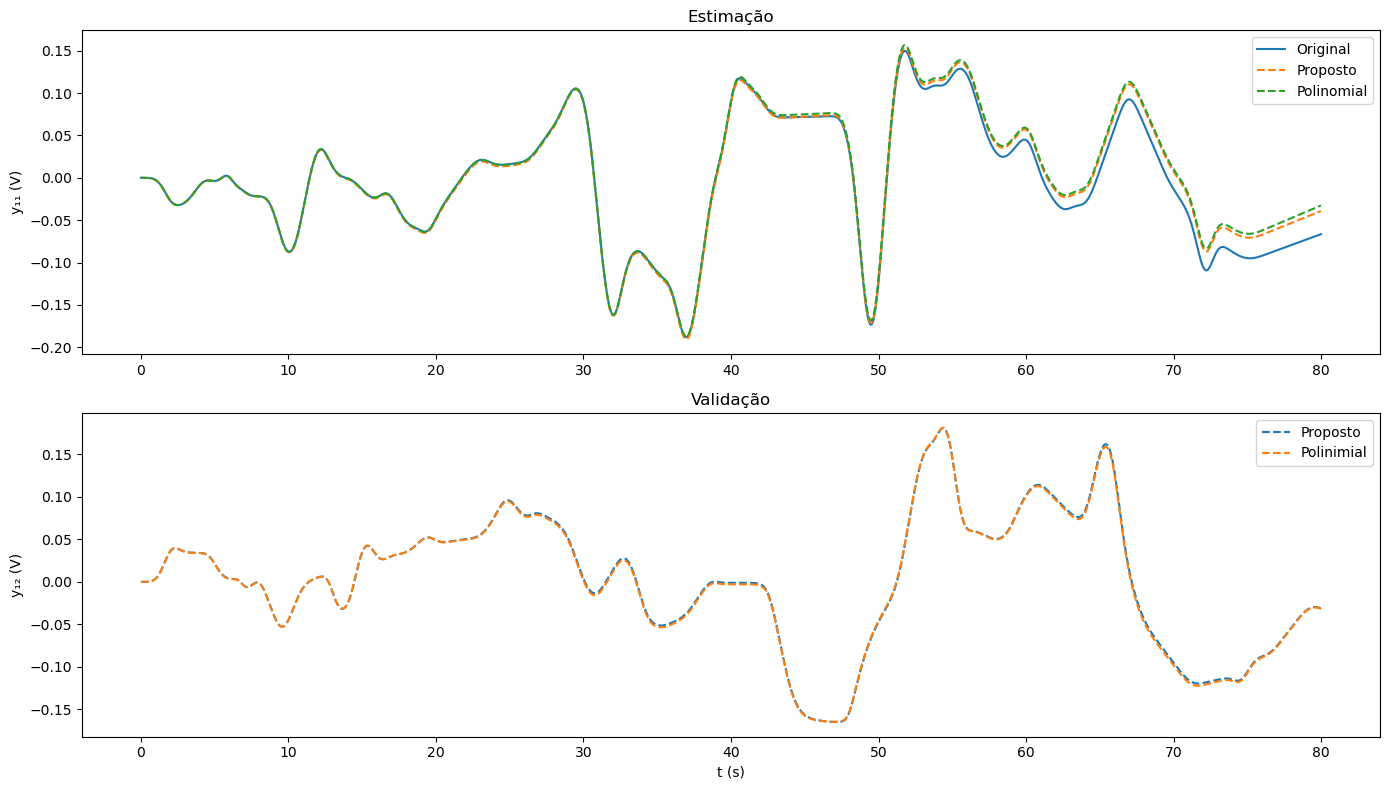

In [13]:

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(t, y, label='Original')
ax[0].plot(t, slivre, '--', label='Proposto')
ax[0].plot(t, polinomial_slivre, '--', label='Polinomial')

ax[0].set_ylabel('y\u2081\u2081 (V)')
#ax[0].set_ylim(-0.1, 4.1)
ax[0].set_title("Estimação")
ax[0].legend()

#ax[1].plot(p, z12, label='Original')
ax[1].plot(tVal, valLivre, '--', label='Proposto')
ax[1].plot(tVal, polinomial_valLivre, '--', label='Polinimial')
ax[1].set_ylabel('y\u2081\u2082 (V)')
ax[1].set_xlabel('t (s)')
#ax[1].set_ylim(-0.1, 4.1)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesComparate.png')

plt.show()

# Narx - com ruido

8 (8, 7996)
[U1.2 Y1.3 Y1.4] [5, 3, 4]
[U1.2 Y1.3 Y1.4]
0.228215660703629*U1.2 + 0.505871159273557*Y1.3 + 0.49390851887794*Y1.4
Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, U1.1, U1.2, U1.3, U1.4]

Simulação livre
RMSE: 0.0009919882326952978 MSE: 9.840406538059404e-07 
AET: 6.430568634238494 
MAPE: 0.37891%

Um passo a frente
RMSE: 0.0009159408911353251 MSE: 8.389477160537736e-07 
AET: 5.889994058125031 
MAPE: 0.41793%


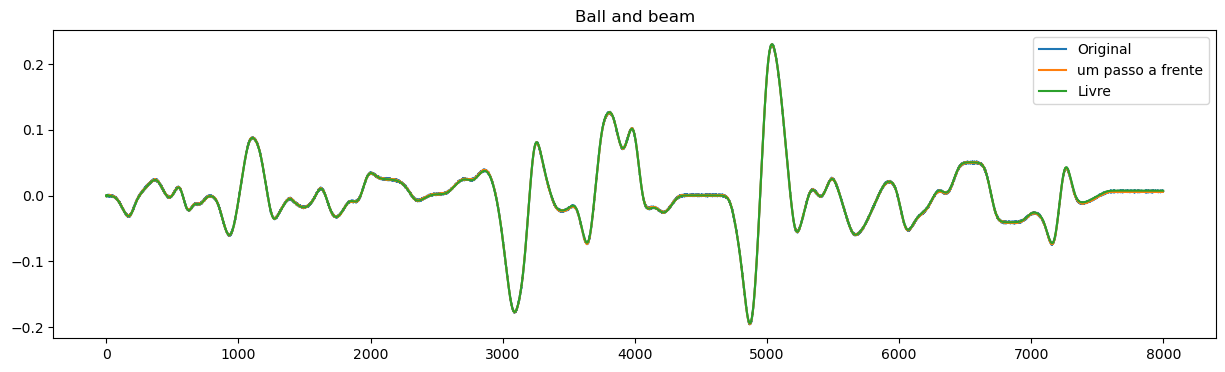

In [89]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.zeros(ui.shape)
yi[0, 1:] = (y[1:] - y[:-1]) / t[1]

output = 0  # 0 ou 1

num = [5]
params = []
params.append({'nb':[4],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff':False})


sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-15)#0.000000001

model = ss[selected]
print(model, selected)

theta = LSM(yi[output, pad:], psi)
#theta1 = recursiveMQ(yi[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


polinomial_slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)

print("\nSimulação livre")
metrics(yi, polinomial_slivre)
print("\nUm passo a frente")
metrics(yi, yhat)

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(yi.T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(polinomial_slivre, label='Livre')
plt.legend()
plt.show()

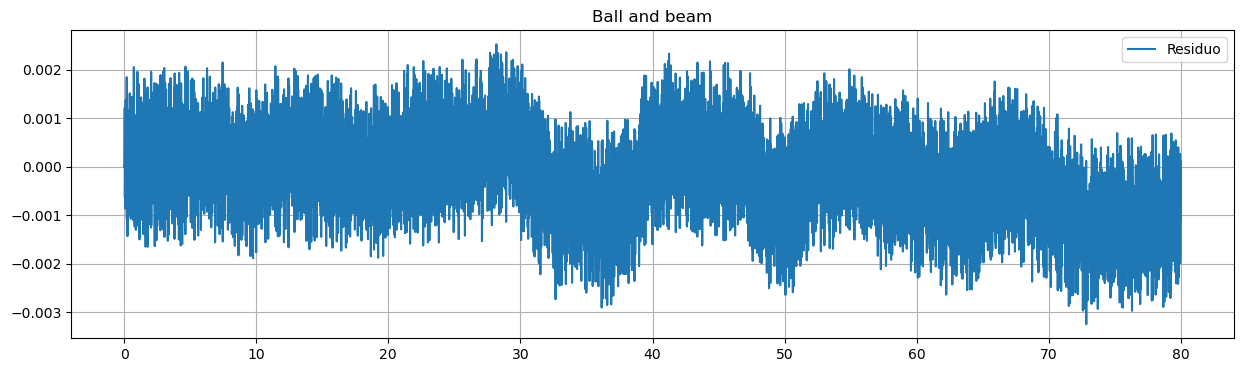

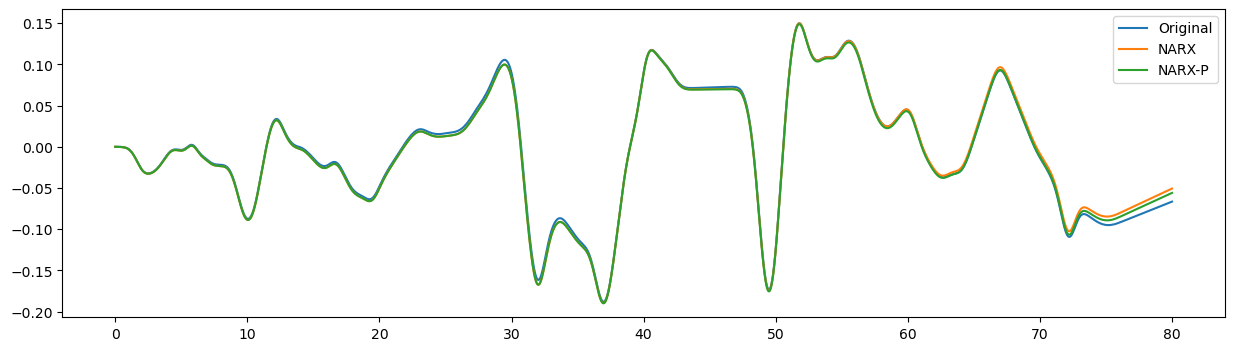

In [90]:

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(t, (yi - polinomial_slivre.T).T, label='Residuo')
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(t, y, label="Original")
plt.plot(t, integrate(polinomial_slivre, ts=dt), label="NARX")
#plt.plot(t, polinomial_slivre, label="NARX")
plt.plot(t, w, label="NARX-P")
plt.legend()
plt.show()

Simulação livre
-------- [Y1.1, Y1.2, Y1.3, Y1.4, U1.1, U1.2, U1.3]
Modelo selecionado:
0.505871183315733⋅Y1.3 + 0.493908657981277⋅Y1.4 + 0.228264264109711⋅sin(U1.2)

Simulação livre
RMSE: 0.08455909939165873 MSE: 0.007150241289928421 
AET: 534.2965939148909 
MAPE: 31.81213%

Um passo a frente
RMSE: 0.002051060538728838 MSE: 4.206849333530632e-06 
AET: 11.327990083334036 
MAPE: 0.13933%


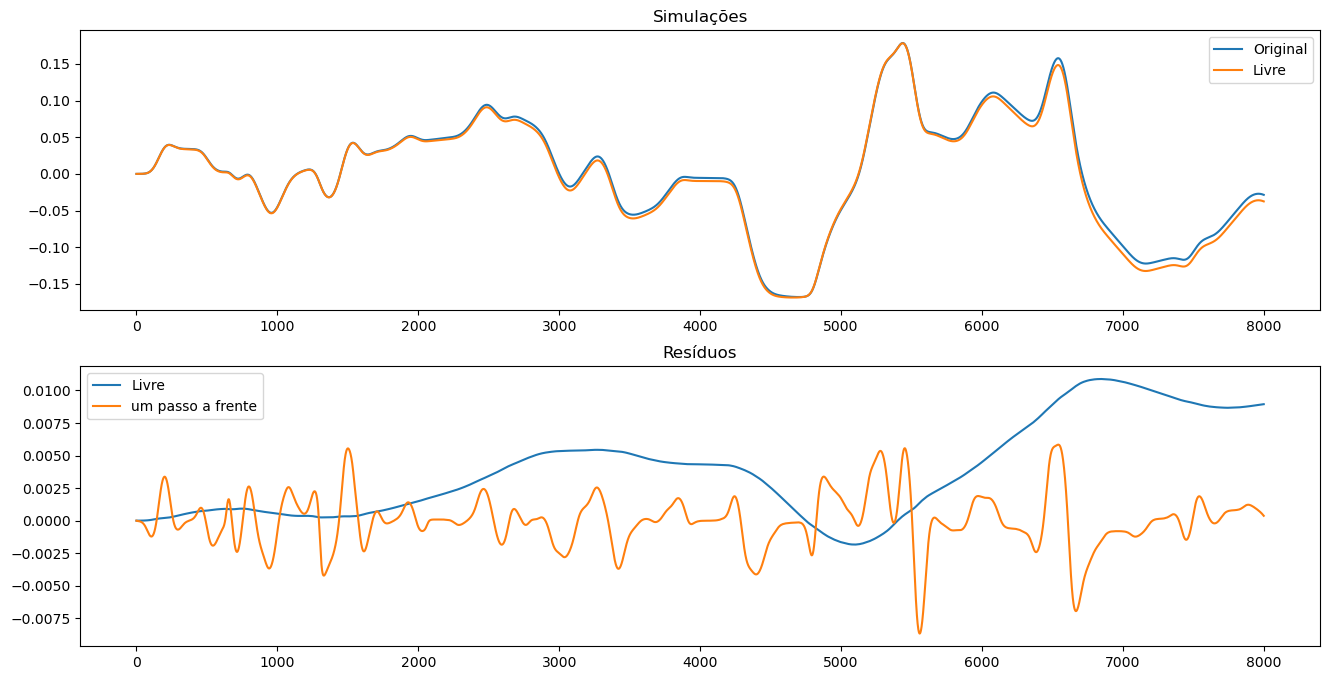

In [25]:
#uVal = UVal
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

print("\nSimulação livre")
metrics(yVal, polinomial_valLivre)
print("\nUm passo a frente")
metrics(yVal, yhat)
f, ax = plt.subplots(2,1, figsize=[16, 8])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(integrate(polinomial_valLivre, ts=tVal[1]), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - integrate(polinomial_valLivre, ts=tVal[1]), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()